# Lab 03 - Regression
## Tasks
- Explore linear regression and overfitting
- Experiment with stocastic gradient descent

# Set up environment

In [1]:
!pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

In [2]:
%reset -f

import os
import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#import toy accelerator package
from uspas_ml.accelerator_toy_models import high_dimensional_data_generator

#import sklearn modules
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#import pytorch
import torch

## Linear regression
We start with simple least squares linear regression. Our model is defined as follows:

$
f(\mathbf{x}) = \mathbf{x}^T\mathbf{w} + \mathbf{b}
$

Our objective is to determine the weights $\mathbf{w}$ and the biases $\mathbf{b}$ for a set of input variables (also referred to as "features") to best model the observed values $y = f(\mathbf{x}) + \epsilon$ where $\epsilon$ represents noise (usually Gaussian noise).

We start by constructing a training set and a test set. We will train the model on the training set and then evaluate the model's abilitiy to correctly predict values from the test set. This (hopefully) allows us to evaluate if the model generalizes well to data outside the test set.

One problem we face is overfitting (see https://en.wikipedia.org/wiki/Overfitting for more details). Here we will try to demonstrate methods for avoiding this problem.

In [3]:
#load dataset - last column is f
from uspas_ml.accelerator_toy_models import data_dir
data = np.load(os.path.join(data_dir, 'complex_dataset.npy'))
true_weights = np.load(os.path.join(data_dir, 'complex_dataset_weights.npy'))

print(data.shape)
x = data[:,:-1]
f = data[:,-1]

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, f, test_size=0.3, random_state=3)
print(X_train.shape)

(1000, 1001)
(700, 1000)


1.0
0.6705457848150063


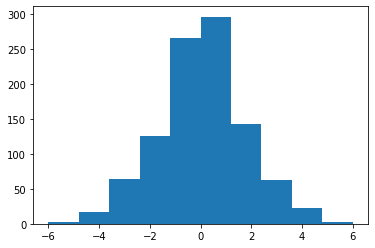

In [4]:
#fit data with a linear model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
reg.coef_

#get training and test scores - least squared distance
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)
print(train_score)
print(test_score)

fig,ax = plt.subplots()
ax.hist(reg.coef_, range = [-6,6]);

<div class="alert alert-block alert-info">
    
**Task:** 
    Refit the data using Ridge and Lasso regression with alpha = 0.01, 100 and plot histogram of weights Hint: use scikit-learn. Also plot a histogram of `true_weights` to compare. Also calculate the training and test scores for each. Which method is best for this data set?
    
</div>

In [5]:
#Ridge regression

In [6]:
#Lasso regression

# Using SGD

## Create some data

torch.Size([70, 1])


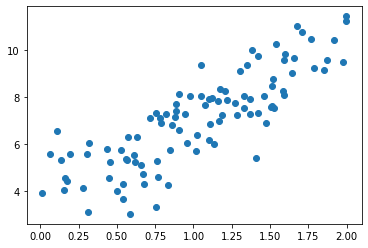

In [17]:
# Vector of 100 random numbers between zero and one; multiply all by 2.
X = 2*np.random.rand(100,1)

# Y(x) + dY, for random values of Y
Y = 4 + 3*X + np.random.randn(100,1)

plt.scatter(X, Y, label='gaussian noise abt. y=4x+3')
print(data.shape)
x = torch.from_numpy(X).float()
f = torch.from_numpy(Y).float()


#add data to dataset objects, which allows us to easily split data into train/test sets and shuffle the data as needed
train_fraction = 0.7
n_train = int(train_fraction*x.shape[0])
n_test = x.shape[0] - n_train
train_data, test_data = torch.utils.data.random_split(torch.utils.data.TensorDataset(x, f), [n_train, n_test])

## Define a model to train

In [10]:
# Define a model class that we will train - represents a linear combination
class LinearModel(torch.nn.Module):
    def __init__(self, n_features):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(n_features, 1)
        
    def forward(self,x):
        return self.linear(x)

# list trainable parameters for linear model if we have 10 inputs
lmodel = LinearModel(2)
for name, item in lmodel.named_parameters():
    print(f'{name}:{item}')


linear.weight:Parameter containing:
tensor([[0.2979, 0.6161]], requires_grad=True)
linear.bias:Parameter containing:
tensor([0.6129], requires_grad=True)


### Modifications to Linear Regression
The analytical solution for the weights using least squares involves matrix inversion, which makes it practically impossible to solve this problem analytically. The least squares loss function is defined as

$
    L(\mathbf{w}) = ||X\mathbf{w} - Y||^2
$

where $X$, $Y$ are matricies with our input and output data respecitvely. To minimize the loss we compute the gradient

$
    \frac{dL}{d\mathbf{w}} = -2X^TY + 2X^TX\mathbf{w} 
$

and set it to zero to find the minimum value for the weights, we get

$
    \mathbf{w} = (X^TX)^{-1}X^T\mathbf{y}
$

If $X$, $Y$ are large (maybe 10k x 10k) then the matrix inversion here becomes computationally impossible. 

Instead, we will optimize the weights numerically. However,computing the gradient is also expensive in this case.  Instead we will approximate the gradient using smaller "batches" of training points.

We divide the entire dataset into batches and use the gradient with respect to these batches as a stand-in for the real gradient. Depending on the batch size we call this method as follows:
- "Batch gradient descent / Gradient descent" -> the batch size is equal to the dataset size
- "Mini-batch gradient descent" -> the batch size is > 1 but less than the dataset size
- "Stochastic gradient descent" -> the batch size is 1

Choosing the correct batch size has a significant effect on optimization speed depedning on the problem at hand. Reducing the batch size can make optimization faster to compute, but takes a noiser path. 

In this case the term "epoch" describes the number of times the optimizer will use the entire dataset during optimization (generally greater than one).

We will start by trying batch gradient descent using `torch.optim.SGD`
#### NOTE: even though the function name is SGD, it depends on how much data you pass it. In this case since we pass it the entire dataset it is effectively batch gradient descent.

In [16]:
epochs = 200
gd_model = LinearModel(x.shape[1])

#use Mean Squared Error loss function
loss_fn = torch.nn.MSELoss()
optim = torch.optim.SGD(gd_model.parameters(), lr = 0.01)

batch_size = len(train_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

#track loss during epochs
train_loss = []
test_loss = []
for i in range(epochs):

    #iterate over the batches (in this case we only have one batch)
    for batch_idx, (data, target) in enumerate(train_loader):
        # zero gradients
        optim.zero_grad()
        
        # calculate model prediction -> calculate loss
        fval = gd_model(data)
        loss = loss_fn(fval, target.reshape(-1,1))
        
        # calculate derivatives of loss based on model parameters
        loss.backward()
    
        # step the optimizer based on the gradients
        optim.step()
        
        # keep track of loss function
        train_loss += [loss.detach().numpy()]
        if i % 5 == 0:
            print(f'epoch: {i}, loss: {loss}')   
            
        #calculate test loss
        test_loss += [loss_fn(gd_model(test_data[:][0]),test_data[:][1].unsqueeze(1)).detach().numpy()]


epoch: 0, loss: 69.19429779052734
epoch: 5, loss: 44.151912689208984
epoch: 10, loss: 28.388065338134766
epoch: 15, loss: 18.464441299438477
epoch: 20, loss: 12.216850280761719
epoch: 25, loss: 8.283098220825195
epoch: 30, loss: 5.805777549743652
epoch: 35, loss: 4.245214939117432
epoch: 40, loss: 3.26171875
epoch: 45, loss: 2.641477584838867
epoch: 50, loss: 2.2499120235443115
epoch: 55, loss: 2.0023140907287598
epoch: 60, loss: 1.8453643321990967
epoch: 65, loss: 1.7455006837844849
epoch: 70, loss: 1.6815980672836304
epoch: 75, loss: 1.6403592824935913
epoch: 80, loss: 1.613412857055664
epoch: 85, loss: 1.5954909324645996
epoch: 90, loss: 1.583274006843567
epoch: 95, loss: 1.5746738910675049
epoch: 100, loss: 1.5683752298355103
epoch: 105, loss: 1.5635496377944946
epoch: 110, loss: 1.5596745014190674
epoch: 115, loss: 1.5564204454421997
epoch: 120, loss: 1.553579330444336
epoch: 125, loss: 1.5510201454162598
epoch: 130, loss: 1.548659086227417
epoch: 135, loss: 1.5464434623718262
epo

Text(0, 0.5, '<MSELoss>')

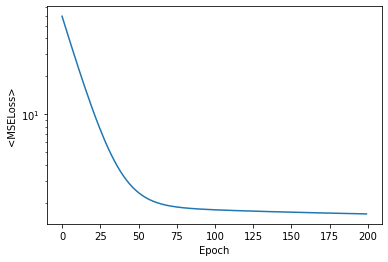

In [15]:
# plot 
#plt.plot(test_loss)
plt.semilogy(train_loss)

plt.xlabel('Epoch')
plt.ylabel('<MSELoss>')

<div class="alert alert-block alert-info">
    
**Task:** 
    Refit the data using stochastic gradient descent (batch size of 1) and mini-batch gradient descent with 10 batches. You will have to change the number of epochs so that it takes a reasonable amount of time (50 for mini-batch and 10 for SGD). Compare how changing batch size effects optimization by plotting test_loss as a function of epoch for each batch size. Compare how mini-batch training changes with varying learning rates (0.001, 0.01, 0.1).
    
</div>

epoch: 0, loss: 0.21927504241466522
epoch: 0, loss: 0.03802037984132767
epoch: 0, loss: 0.03776510804891586
epoch: 0, loss: 0.03762199729681015
epoch: 0, loss: 0.03860285133123398
epoch: 0, loss: 0.03785426542162895
epoch: 0, loss: 0.03775765746831894
epoch: 5, loss: 0.03770924732089043
epoch: 5, loss: 0.036999646574258804
epoch: 5, loss: 0.03810597583651543
epoch: 5, loss: 0.037492841482162476
epoch: 5, loss: 0.03750311955809593
epoch: 5, loss: 0.03683830425143242
epoch: 5, loss: 0.038779366761446
epoch: 10, loss: 0.03756172955036163
epoch: 10, loss: 0.03689240291714668
epoch: 10, loss: 0.03719107806682587
epoch: 10, loss: 0.037084031850099564
epoch: 10, loss: 0.03745623305439949
epoch: 10, loss: 0.0367610827088356
epoch: 10, loss: 0.03753230720758438
epoch: 15, loss: 0.03683082014322281
epoch: 15, loss: 0.036799073219299316
epoch: 15, loss: 0.037143394351005554
epoch: 15, loss: 0.03729584068059921
epoch: 15, loss: 0.036460619419813156
epoch: 15, loss: 0.03632970154285431
epoch: 15, l

Text(0, 0.5, '<MSELoss>')

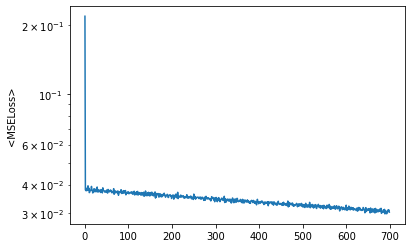

epoch: 0, test_loss: 0.00817880965769291
epoch: 1, test_loss: 0.0044096531346440315
epoch: 2, test_loss: 0.004629952367395163
epoch: 3, test_loss: 0.00626334547996521
epoch: 4, test_loss: 0.0058640772476792336
epoch: 5, test_loss: 0.0066016060300171375
epoch: 6, test_loss: 0.004276455845683813
epoch: 7, test_loss: 0.004697387106716633
epoch: 8, test_loss: 0.005313584581017494
epoch: 9, test_loss: 0.005357528571039438


Text(0, 0.5, '<MSELoss>')

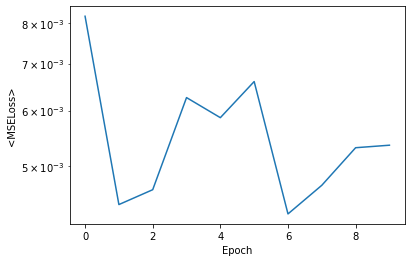

<div class="alert alert-block alert-success">
    
**Homework:**
    Provide an explaniation for why the MSE performance of gradient based methods varies so dramatically based on batch size.
</div>

<div class="alert alert-block alert-success">
    
**Homework:**
    How could we extend this method towards modeling more complex functions? Use a pytorch model to perform polynomial
    regression of the dataset generated below. Your answer should closely match the analytical function used to generate the data.
    Hint: You can access the weight elements of nn.Linear layer using `.weight`, see above for use.
</div>

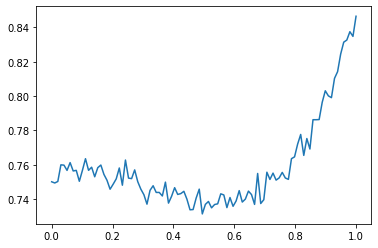

In [18]:
x = torch.linspace(0,1, 100).unsqueeze(dim=1)
y = 0.75 + 0.1 * x - 0.5 * x ** 2 + 0.5 * x ** 3 + torch.randn(x.shape)*0.005
plt.plot(x,y)

tensor(2.5373e-05, grad_fn=<MseLossBackward>)
linear.weight:Parameter containing:
tensor([[ 0.0121, -0.2899,  0.3612]], requires_grad=True)
linear.bias:Parameter containing:
tensor([0.7585], requires_grad=True)


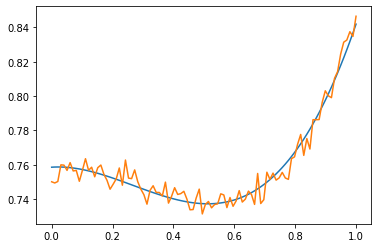